In [1]:
# -----------------------------------------------------------
# This script serves as the main function to clean, process, and classify datasets.
#
# Author: Konghao Zhao
# Created: 2023-10-05
# Modified: 2023-11-15
# 
# -----------------------------------------------------------

In [4]:
import warnings, os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request as ur

from sklearn.pipeline import Pipeline
from dataObject import (NaColumnsHandler, NaHandler, duplicateHandler, rowOutlierChecker, correlatedFeatureRemover, 
                        normalizer, variableFeaturesSelector, pcaReducer, audit_data, umapReducer)

In [10]:
################################### read data ###################################
label = "W2CL1R"
data = pd.read_csv("../data/ICPSR_36371/DS0001/36371-0001-Data.tsv", sep="\t", na_values=[" "])

#################################### data auditing ###################################
report = audit_data(data, duplicateRow = True, duplicateCol = True, NaN = True, column_NaN = True,  maxNA = 0.51)

#################################### data cleaning ###################################
print(f"{'*'*30} Data Cleaning {'*'*30}")
dataCleaner = Pipeline([
                        ("NaColumnsHandler", NaColumnsHandler(columnNames=report["Large_NAs_columns"])),
                        ("NaHandler", NaHandler(indices=report["NaN"], evaluation=False)),
                        ("logNormalizer", duplicateHandler(indices=report["duplicate"], evaluation=False)),
                        ("rowOutlierChecker", rowOutlierChecker(stdScale=3, evaluation=False)),
                        ])
data = dataCleaner.fit_transform(data)

target = data[[label]]
data = data.drop(columns=[label])

#################################### features processing ###################################
print(f"{'*'*30} Select Features {'*'*30}")
pc_feature_selector = Pipeline([
                    ("correlatedFeatureRemover", correlatedFeatureRemover(upperBound=0.98)),
                    ("normalizer", normalizer(lowerBound=-1,upperBound=1)), 
                    ("variableFeaturesSelector", variableFeaturesSelector(numFeatures=100)),
                    ("pca", pcaReducer(criteria=0.98))
                    ])

umap_feature_selector = Pipeline([
                    ("umap", umapReducer())
                    ])

pca_data = pc_feature_selector.fit_transform(data)
umap_data = umap_feature_selector.fit_transform(pca_data)

****************************** Data Auditing ******************************
Find 530 columns with more than 51.0% N/A
Find 3661 rows with NaN
Find 12 duplicated columns
****************************** Data Cleaning ******************************
---------- Handle Large NaN columns ----------
Drop 530 columns that have execessive N/As
Dataset shape: (3661, 257)
---------- Handle NaN values ----------
Drop 2630 rows with N/As
Dataset shape: (1031, 257)
---------- Handle duplicates ----------
Dataset shape: (1031, 255)
---------- Filter Rows ----------
Drop 0 out of distribution rows
****************************** Select Features ******************************
Drop 38 highly correlated columns with 0.98 upper_bound
Dataset shape: (1031, 216)
Normalize Dataset
Select 100 highly variable features
Dataset shape: (1031, 100)
Select 0.98 principle component
Dataset shape: (1031, 66)
Reduce data to 2 UMAP component


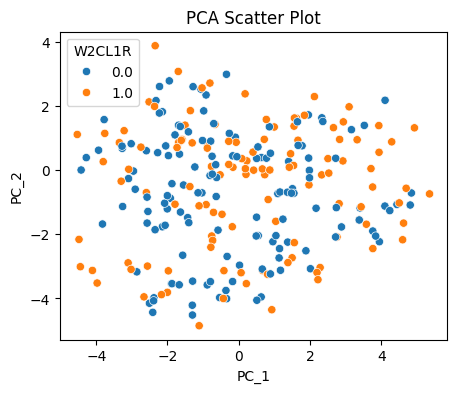

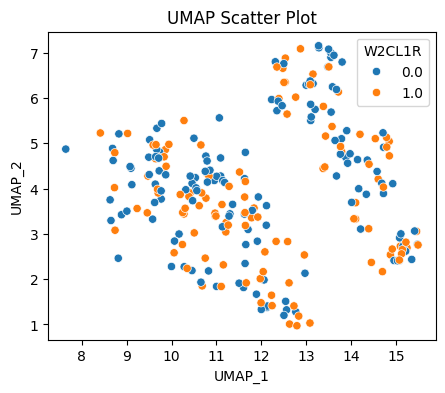

In [11]:
pca_df = pd.concat([pca_data, target.reset_index(drop=True)], axis=1)
umap_df = pd.concat([umap_data, target.reset_index(drop=True)], axis=1)

plt.figure(figsize=(5, 4))
sns.scatterplot(data=pca_df, x='PC_1', y='PC_2', hue=label)
plt.title('PCA Scatter Plot')
plt.show()

# Plot UMAP Data
plt.figure(figsize=(5, 4))
sns.scatterplot(data=umap_df, x='UMAP_1', y='UMAP_2', hue=label)
plt.title('UMAP Scatter Plot')
plt.show()